In [23]:
import sys
sys.path.insert(0,'..')

# Compute Embeddings 

In [89]:
import pandas as pd
from src import embeddings

df = pd.read_csv('../output/armando_all_features_global_prediction.csv')
headlines = list(df['headline'])
# hl_embeddings = embeddings.bert(headlines)

In [90]:
# normalize df['ctr']
mu = df['ctr'].mean()
sigma = df['ctr'].std()

df['ctr']=(df['ctr']-mu)/sigma
df['ctr']

0        0.252049
1        0.520419
2        0.513248
3        0.134193
4       -0.041614
           ...   
59995   -0.272440
59996   -0.546174
59997   -0.804875
59998    1.539790
59999   -0.148176
Name: ctr, Length: 60000, dtype: float64

In [91]:
mu, sigma

(0.013374298447697833, 0.011262850831548153)

In [92]:
import pickle
import numpy as np

hle_fname = '../output/hl_embeddings_armando_all_features_global_prediction.pkl'
hl_embeddings = pickle.load(open(hle_fname, "rb"))
hl_embeddings = np.array(hl_embeddings)
hl_embeddings.shape

(60000, 384)

In [60]:
# from src import utils
# utils.write_pkl(hl_embeddings, '../output/hl_embeddings_armando_all_features_global_prediction.pkl')
# hl_embeddings = np.array(hl_embeddings)
# hl_embeddings.shape

(60000, 384)

In [93]:
import datetime 
# df['test_week_str'] = df['test_week'].apply(lambda x: f'{x//100}-W{x%100}')
# df['test_week_dt'] = df['test_week_str'].apply(lambda x: datetime.datetime.strptime(x + '-1', "%Y-W%W-%w"))
# df[['test_week_str', 'test_week_dt']]
df['test_week'] = df['test_week'].astype('datetime64[ns]')

In [94]:
from math import ceil

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

In [95]:
# Get the list with seconds since earliest event
date_features = list(df['test_week']) # list(df['test_week_dt'])
# date_features = [(i - min(date_features)).total_seconds() for i in date_features]
# # Normalize data so it lies between 0 and 1
# date_features = [i/max(date_features) for i in date_features]
date_features = [[test_week.month, week_of_month(test_week)] for test_week in date_features] # add week of month and  month

In [96]:
dates_df = pd.DataFrame(date_features)
dates_df

,0,1
0,6,2
1,6,4
2,6,4
3,6,4
4,8,2
...,...,...
59995,4,5
59996,6,6
59997,9,4
59998,4,5


In [97]:
months_df = pd.get_dummies(dates_df[0])
weeks_df = pd.get_dummies(dates_df[1])

In [98]:
dates_df[0].value_counts(), dates_df[1].value_counts()

(9     7398
 10    5985
 8     5560
 6     5308
 4     5160
 3     5130
 7     5064
 11    4975
 12    4679
 2     4259
 1     3693
 5     2789
 Name: 0, dtype: int64,
 3    14473
 4    14114
 5    13692
 2    13385
 1     2448
 6     1888
 Name: 1, dtype: int64)

In [99]:
months_embeddings, week_embeddings = months_df.to_numpy(), weeks_df.to_numpy()

In [100]:
hl_embeddings.shape, months_embeddings.shape, week_embeddings.shape

((60000, 384), (60000, 12), (60000, 6))

In [144]:
ner_keys = ['LOC', 'PERSON', 'WORK_OF_ART','LANGUAGE','PRODUCT','QUANTITY','DATE','CARDINAL','GPE','TIME','ORG','LAW','MONEY','FAC','EVENT','PERCENT','NORP','ORDINAL']
ner_cols = [f'{k}_start' for k in ner_keys] # + [f'{k}_end' for k in ner_keys]
other_features = ['hl_len', 'neg', 'neu', 'pos'] + ner_cols
df[ner_cols] = df[ner_cols].astype('bool').astype('int')

other_embeddings = df[other_features].to_numpy()

In [141]:
other_embeddings

array([[0, 1, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [126]:
other_embeddings.shape

(60000, 36)

In [149]:
X = np.concatenate((other_embeddings,), axis=1) # hl_embeddings, months_embeddings, week_embeddings, 
y = np.array(df['ctr'].tolist())

In [143]:
X.shape, y.shape

((60000, 36), (60000,))

# Predict 

In [150]:
import torch
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader

class PackagesDataset(torch.utils.data.Dataset):
    """
    Prepare the Packages dataset for regression
    """

    def __init__(self, X, y, scale_data=True):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # Apply scaling if necessary
            if scale_data:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]


class MLP(nn.Module):
    """
      Multilayer Perceptron for regression.
    """

    def __init__(self, in_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        """
          Forward pass
        """
        return self.layers(x)

In [153]:
NB_EPOCHS = 30
# Set fixed random number seed
torch.manual_seed(42)

# Load Packages dataset
# X, y = load_packages()

# Prepare Packages dataset
dataset = PackagesDataset(X, y)

# Split Packages dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create trainloader object
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=1)

# Create testloader object
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=1)

# Initialize the MLP
mlp = MLP(in_size=X.shape[1])

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)


losses = {'train': [], 'test': []}
epochs = range(NB_EPOCHS)


def train(epoch):
     # Print epoch
    print(f'Starting epoch {epoch + 1}')

    mlp.train()
    
    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):

        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
    
    current_loss /= len(trainloader)
    
    losses['train'].append(current_loss)
    
    print('Train Loss: %.3f'%(current_loss))

    
def test(epoch):
    mlp.eval()

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(testloader, 0):

        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Print statistics
        current_loss += loss.item()
    
    current_loss /= len(testloader)
    
    losses['test'].append(current_loss)
    
    print('Test Loss: %.3f'%(current_loss))

# Run the training loop
for epoch in epochs:
    train(epoch)
    test(epoch)

Starting epoch 1
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Train Loss: 0.936
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Test Loss: 0.824
Starting epoch 2
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variab

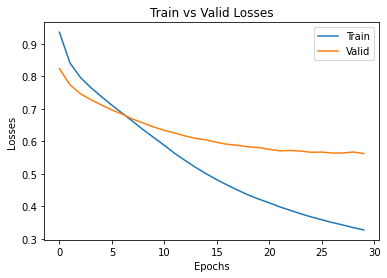

In [154]:
import matplotlib.pyplot as plt

plt.plot(losses['train'])
plt.plot(losses['test'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
 
plt.show()

In [79]:
min(losses['test'])

0.5614742592294165

In [52]:
def aug(x, y):
    return 100*abs(x - y)/y

aug(5692112896036594, 6325511279258322)

10.013394257926217

# Examples

In [56]:
headlines = [
    'Oxford is better than Harvad, Here is why.',
    'Oxford is better than Harvad, Here is why.',
    'Prince of Sussex is having dinner in Paris tonight.',
    'Prince of Sussex is having dinner in Paris tonight.',
    'Happy new year!',
    'Happy new year!',
]

dates = np.array([
    [1, 1],
    [4, 4]
])

In [57]:
hl_embeddings = embeddings.bert(headlines)

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [58]:
X = np.array(hl_embeddings)

mlp(torch.tensor(X))*sigma + mu

RuntimeError: mat1 and mat2 shapes cannot be multiplied (7x384 and 385x64)

In [46]:
# torch.save(mlp.state_dict(), '../output/mlp_global_prediction_500_epochs.pt')